# Chapter 02: Inference Algorithms

This notebook explores the different Bayesian inference algorithms available in vangja. We'll use the multiplicative model from the Air Passengers dataset to compare:

1. **Maximum A Posteriori (MAP)** - Point estimates
2. **Variational Inference (ADVI)** - Approximate posterior
3. **Markov Chain Monte Carlo (NUTS)** - Full posterior sampling

Each method offers different trade-offs between computational speed and the richness of uncertainty quantification.

> **Reference**: For a detailed exploration of these Bayesian inference techniques in time series forecasting, see Krajevski & Tojtovska Ribarski (2026): [*Going NUTS with ADVI: Exploring various Bayesian Inference techniques with Facebook Prophet*](https://arxiv.org/abs/2601.20120), arXiv:2601.20120.

## Setup and Imports

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.datasets import load_air_passengers
from vangja.utils import metrics

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## Load and Prepare Data

We'll use the same Air Passengers dataset from the Getting Started notebook.

In [4]:
# Load Air Passengers dataset from vangja.datasets
air_passengers = load_air_passengers()

# Split data: use last 12 months for testing
train = air_passengers[:-12].copy()
test = air_passengers[-12:].copy()

print(f"Training set: {train['ds'].min()} to {train['ds'].max()} ({len(train)} samples)")
print(f"Test set: {test['ds'].min()} to {test['ds'].max()} ({len(test)} samples)")

Training set: 1949-01-01 00:00:00 to 1959-12-01 00:00:00 (132 samples)
Test set: 1960-01-01 00:00:00 to 1960-12-01 00:00:00 (12 samples)


## Define the Multiplicative Model

We'll use a multiplicative model that captures the increasing variance with trend:

$$y(t) = g(t) \cdot (1 + s(t)) + \epsilon$$

where $g(t)$ is the linear trend and $s(t)$ is the combined seasonality.

In [5]:
def create_model():
    """Create a fresh multiplicative model instance."""
    return LinearTrend(n_changepoints=25) ** (
        FourierSeasonality(period=365.25, series_order=10)
        + FourierSeasonality(period=7, series_order=3)
    )

print(f"Model structure: {create_model()}")

Model structure: LT(n=25,r=0.8,tm=None) * (1 + FS(p=365.25,n=10,tm=None) + FS(p=7,n=3,tm=None))


---

## 1. Maximum A Posteriori (MAP) Estimation

### What is MAP?

Maximum A Posteriori (MAP) estimation finds the **single most probable parameter values** given the data and priors. Mathematically, MAP finds:

$$\hat{\theta}_{MAP} = \arg\max_{\theta} P(\theta | D) = \arg\max_{\theta} P(D | \theta) \cdot P(\theta)$$

where $P(D | \theta)$ is the likelihood and $P(\theta)$ is the prior.

**Advantages:**
- Very fast computation
- Good for quick prototyping and model comparison
- Works well when you have enough data

**Limitations:**
- Provides only a point estimate (no uncertainty quantification)
- Can get stuck in local optima
- Doesn't capture the full shape of the posterior distribution

### PyMC's `map` vs pymc-extras' `mapx`

Vangja supports two MAP implementations:

| Feature | `map` (PyMC) | `mapx` (pymc-extras) |
|---------|--------------|----------------------|
| Backend | SciPy optimizers | JAX-based optimization |
| Speed | Slower | **Significantly faster** |
| Gradient computation | Numerical or PyTensor | JAX autodiff |
| Recommended | Legacy support | **Default choice** |

The `mapx` method from pymc-extras uses JAX for automatic differentiation, resulting in much faster optimization, especially for models with many parameters.

### 1.1 MAP with `mapx` (Recommended)

In [6]:
# Create and fit the model using mapx (default)
model_mapx = create_model()

start_time = time.time()
model_mapx.fit(train, method="mapx")
mapx_time = time.time() - start_time

print(f"MAPX fitting time: {mapx_time:.2f} seconds")

Output()

MAPX fitting time: 4.13 seconds


In [7]:
# Predict and evaluate
future_mapx = model_mapx.predict(horizon=365, freq="D")
metrics_mapx = metrics(test, future_mapx, "complete")

print("MAPX Metrics:")
display(metrics_mapx)

MAPX Metrics:


,mse,rmse,mae,mape
series,629.010786,25.080087,21.254398,0.04267


### 1.2 MAP with `map` (Standard PyMC)

In [8]:
# Create and fit the model using standard PyMC map
model_map = create_model()

start_time = time.time()
model_map.fit(train, method="map")
map_time = time.time() - start_time

print(f"MAP fitting time: {map_time:.2f} seconds")
print(f"Speedup with mapx: {map_time / mapx_time:.1f}x faster")

Output()

MAP fitting time: 6.47 seconds
Speedup with mapx: 1.6x faster


In [9]:
# Predict and evaluate
future_map = model_map.predict(horizon=365, freq="D")
metrics_map = metrics(test, future_map, "complete")

print("MAP Metrics:")
display(metrics_map)

MAP Metrics:


,mse,rmse,mae,mape
series,648.633502,25.468284,21.179644,0.042348


---

## 2. Variational Inference (ADVI)

### What is Variational Inference?

Variational Inference (VI) approximates the true posterior distribution $P(\theta | D)$ with a simpler distribution $Q(\theta)$ from a tractable family. The goal is to minimize the **Kullback-Leibler (KL) divergence** between $Q$ and the true posterior:

$$Q^* = \arg\min_Q KL(Q(\theta) || P(\theta | D))$$

### Automatic Differentiation Variational Inference (ADVI)

ADVI is a specific VI algorithm that:
1. Transforms all parameters to unconstrained space
2. Approximates the posterior with a multivariate Gaussian
3. Uses gradient-based optimization to find the best approximation

**Advantages:**
- Much faster than MCMC
- Provides uncertainty estimates (unlike MAP)
- Scales well to large datasets

**Limitations:**
- Approximation may miss multimodal posteriors
- Gaussian assumption may be too restrictive
- Can underestimate uncertainty

### Variants

| Method | Description |
|--------|-------------|
| `advi` | Mean-field approximation (diagonal covariance) |
| `fullrank_advi` | Full covariance matrix (captures correlations) |

In [10]:
# Create and fit the model using ADVI
model_advi = create_model()

start_time = time.time()
model_advi.fit(train, method="advi", samples=1000, progressbar=True)
advi_time = time.time() - start_time

print(f"ADVI fitting time: {advi_time:.2f} seconds")

Output()

Finished [100%]: Average Loss = -3.4217


ADVI fitting time: 20.27 seconds


In [11]:
# Predict and evaluate
future_advi = model_advi.predict(horizon=365, freq="D")
metrics_advi = metrics(test, future_advi, "complete")

print("ADVI Metrics:")
display(metrics_advi)

ADVI Metrics:


,mse,rmse,mae,mape
series,618.449854,24.868652,22.131705,0.044974


---

## 3. Markov Chain Monte Carlo (NUTS)

### What is MCMC?

Markov Chain Monte Carlo (MCMC) methods generate samples from the posterior distribution by constructing a Markov chain that has the posterior as its stationary distribution. After enough iterations, the samples approximate the true posterior.

### No-U-Turn Sampler (NUTS)

NUTS is an advanced MCMC algorithm that:
1. Uses Hamiltonian dynamics to propose distant moves
2. Automatically tunes the trajectory length (no manual tuning needed)
3. Avoids random walk behavior, leading to efficient exploration

**Advantages:**
- Provides the **gold standard** for posterior inference
- Captures the full posterior distribution, including multimodality
- Accurate uncertainty quantification
- Diagnostic tools available (R-hat, ESS, divergences)

**Limitations:**
- Computationally expensive
- Requires tuning (warmup/burn-in period)
- May have convergence issues for complex models

### Sampler Backends

Vangja supports multiple NUTS backends:

| Backend | Description |
|---------|-------------|
| `pymc` | Default PyMC sampler |
| `nutpie` | Fast Rust-based sampler |
| `numpyro` | JAX-based sampler (GPU support) |
| `blackjax` | JAX-based sampler |

In [12]:
# Create and fit the model using NUTS
# Using fewer samples for demonstration (increase for production)
model_nuts = create_model()

start_time = time.time()
model_nuts.fit(
    train,
    method="nuts",
    samples=1000,     # Number of posterior samples per chain
    chains=4,         # Number of independent chains
    cores=4,          # Parallel cores to use
    progressbar=True
)
nuts_time = time.time() - start_time

print(f"NUTS fitting time: {nuts_time:.2f} seconds")

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lt_0 - slope, lt_0 - intercept, lt_0 - delta, fs_0 - beta(p=365.25,n=10), fs_1 - beta(p=7,n=3), sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 190 seconds.


NUTS fitting time: 191.73 seconds


In [13]:
# Predict and evaluate
future_nuts = model_nuts.predict(horizon=365, freq="D")
metrics_nuts = metrics(test, future_nuts, "complete")

print("NUTS Metrics:")
display(metrics_nuts)

NUTS Metrics:


,mse,rmse,mae,mape
series,699.215687,26.442687,22.327201,0.044694


---

## Comparison of Results

Let's compare all inference methods side by side.

In [14]:
# Combine all metrics
comparison = pd.DataFrame({
    "Method": ["MAPX", "MAP", "ADVI", "NUTS"],
    "Time (s)": [mapx_time, map_time, advi_time, nuts_time],
    "RMSE": [
        metrics_mapx["rmse"].values[0],
        metrics_map["rmse"].values[0],
        metrics_advi["rmse"].values[0],
        metrics_nuts["rmse"].values[0]
    ],
    "MAE": [
        metrics_mapx["mae"].values[0],
        metrics_map["mae"].values[0],
        metrics_advi["mae"].values[0],
        metrics_nuts["mae"].values[0]
    ],
    "MAPE": [
        metrics_mapx["mape"].values[0],
        metrics_map["mape"].values[0],
        metrics_advi["mape"].values[0],
        metrics_nuts["mape"].values[0]
    ]
})

print("\nComparison of Inference Methods:")
display(comparison)


Comparison of Inference Methods:


,Method,Time (s),RMSE,MAE,MAPE
0,MAPX,4.130976,25.080087,21.254398,0.042670
1,MAP,6.466574,25.468284,21.179644,0.042348
2,ADVI,20.269035,24.868652,22.131705,0.044974
3,NUTS,191.726867,26.442687,22.327201,0.044694


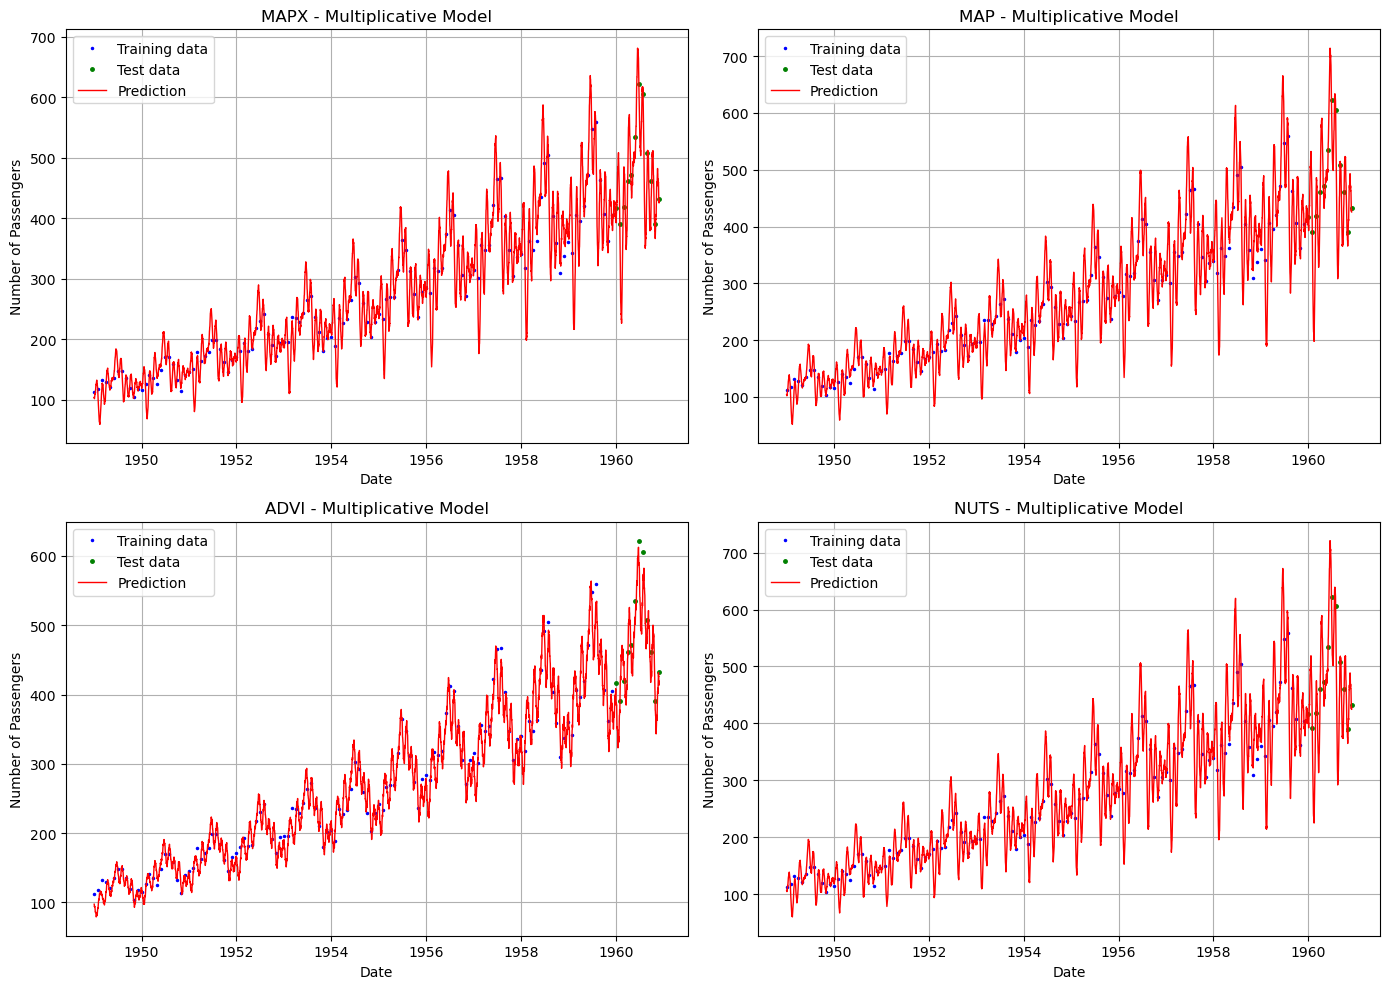

In [15]:
# Visual comparison of predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

methods = [
    ("MAPX", future_mapx),
    ("MAP", future_map),
    ("ADVI", future_advi),
    ("NUTS", future_nuts)
]

for ax, (name, future) in zip(axes.flat, methods):
    ax.plot(train["ds"], train["y"], "b.", label="Training data", markersize=3)
    ax.plot(test["ds"], test["y"], "g.", label="Test data", markersize=5)
    ax.plot(future["ds"], future["yhat_0"], "r-", label="Prediction", linewidth=1)
    ax.set_title(f"{name} - Multiplicative Model")
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Passengers")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

---

## Summary: Choosing an Inference Method

| Method | Speed | Uncertainty | Best For |
|--------|-------|-------------|----------|
| **MAPX** | ⚡⚡⚡ Fastest | ❌ None | Quick prototyping, model selection, production with large data |
| **MAP** | ⚡⚡ Fast | ❌ None | Legacy compatibility |
| **ADVI** | ⚡⚡ Fast | ✅ Approximate | When you need uncertainty but MCMC is too slow |
| **NUTS** | ⚡ Slow | ✅✅ Full | Research, when accuracy matters most, small to medium data |

### Transfer Learning Consideration

When using vangja's transfer learning capabilities (fitting short time series with priors from long time series), MCMC methods are particularly valuable because:
- They capture the full posterior from the long time series
- The posterior can be used directly as a prior for the short series
- Uncertainty propagates correctly through the transfer process